## Project Description

## Import Dependencies

In [1]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

## Environment Testing

In [2]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

## Model Training

In [3]:
env = gym.make(env_name)
env = DummyVecEnv([lambda: env])

model = PPO('MlpPolicy', env, verbose=1)

Using cpu device


In [4]:
model.learn(total_timesteps=10000)

-----------------------------
| time/              |      |
|    fps             | 1593 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009316474 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | 0.000921    |
|    learning_rate        | 0.0003      |
|    loss                 | 6.03        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 48.8        |
-----------------------------------------
----------------------------------

In [5]:
sum_episode_scores = []

for episode in range(1, 100):    ## total 10 episodes
    score = 0                   ## reward init
    obs = env.reset()         ## observations
    done = False                ## episode completes will make done True

    for state in range(500):
        env.render()
        action, _ = model.predict(obs)
        n_state, reward, done, info = env.step(action)      ## apply action 
        if (abs(n_state[0][0]) > 2.4 or abs(n_state[0][2]) > 0.209):
            break

        score += reward        

    print('Episode:', episode, ';   Score:', score)
    sum_episode_scores.append(score)


print("Average score is ", sum(sum_episode_scores) / len(sum_episode_scores))

env.close()

Episode: 1 ;   Score: [253.]
Episode: 2 ;   Score: [500.]
Episode: 3 ;   Score: [176.]
Episode: 4 ;   Score: [500.]
Episode: 5 ;   Score: [500.]
Episode: 6 ;   Score: [500.]
Episode: 7 ;   Score: [268.]
Episode: 8 ;   Score: [500.]
Episode: 9 ;   Score: [500.]
Episode: 10 ;   Score: [238.]
Episode: 11 ;   Score: [500.]
Episode: 12 ;   Score: [500.]
Episode: 13 ;   Score: [500.]
Episode: 14 ;   Score: [500.]
Episode: 15 ;   Score: [500.]
Episode: 16 ;   Score: [500.]
Episode: 17 ;   Score: [500.]
Episode: 18 ;   Score: [298.]
Episode: 19 ;   Score: [77.]
Episode: 20 ;   Score: [500.]
Episode: 21 ;   Score: [500.]
Episode: 22 ;   Score: [500.]
Episode: 23 ;   Score: [500.]
Episode: 24 ;   Score: [500.]
Episode: 25 ;   Score: [500.]
Episode: 26 ;   Score: [500.]
Episode: 27 ;   Score: [9.]
Episode: 28 ;   Score: [185.]
Episode: 29 ;   Score: [500.]
Episode: 30 ;   Score: [500.]
Episode: 31 ;   Score: [500.]
Episode: 32 ;   Score: [500.]
Episode: 33 ;   Score: [500.]
Episode: 34 ;   Score:

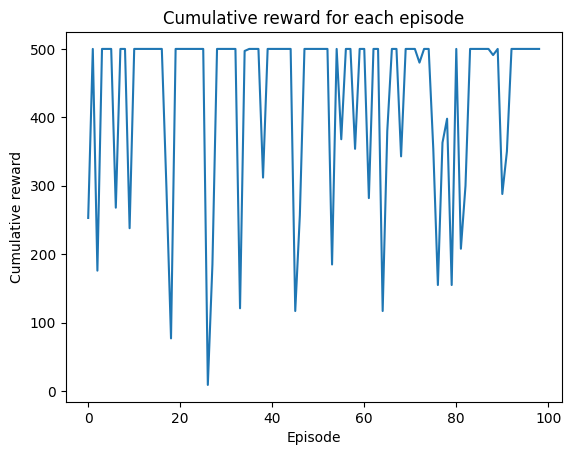

In [6]:
plt.plot(sum_episode_scores)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")
plt.show()